In [39]:
import matplotlib.pyplot as plt
import os

from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    BatchNormalization,
    Activation,
    MaxPooling2D,
)
from keras.models import Sequential

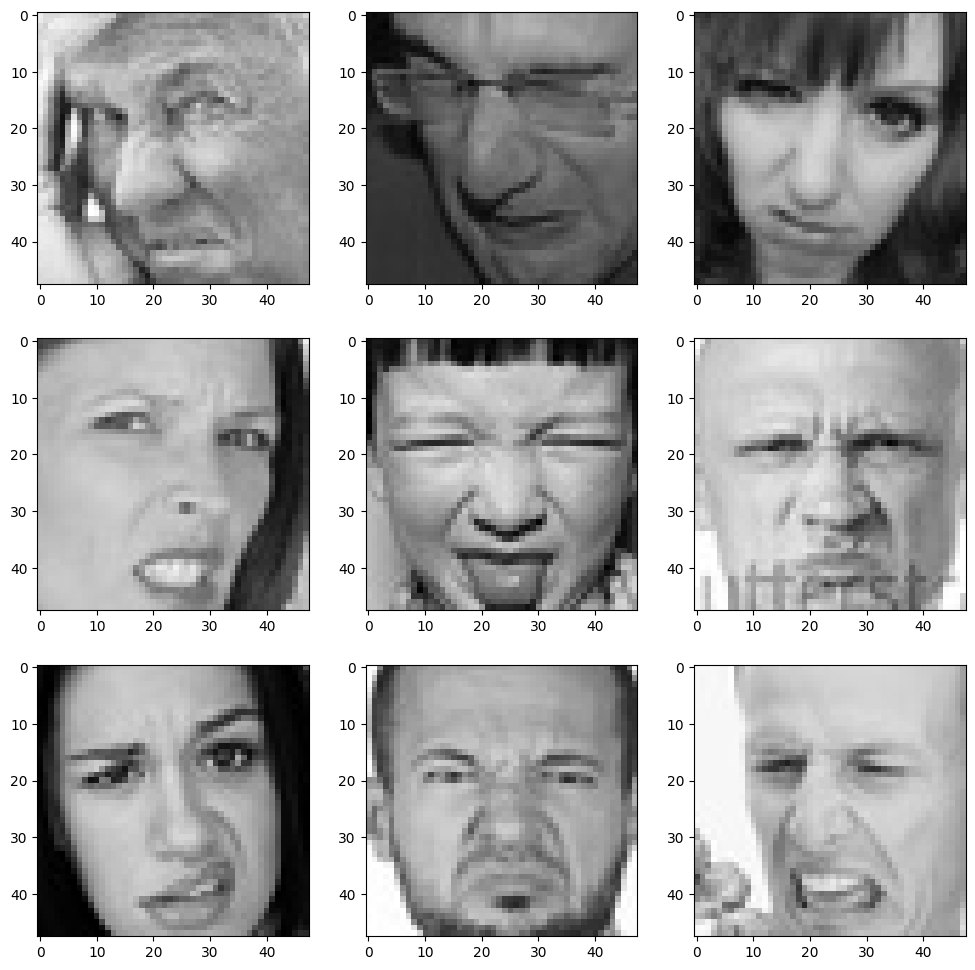

In [40]:
# Displaying Images

picture_size = 48
folder_path = "/kaggle/input/face-expression-recognition-dataset/images/"
expression = "disgust"

plt.figure(figsize=(12, 12))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)
    img = load_img(
        folder_path
        + "train/"
        + expression
        + "/"
        + os.listdir(folder_path + "train/" + expression)[i],
        target_size=(picture_size, picture_size),
    )
    plt.imshow(img)
plt.show()

In [41]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import cv2

# Hàm để tải tất cả dữ liệu từ thư mục
def load_data_from_directory(folder_path, picture_size):
    images = []
    labels = []
    label_map = {}
    
    # Duyệt qua tất cả thư mục trong thư mục chính (mỗi thư mục là một lớp)
    class_dirs = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    
    for idx, class_dir in enumerate(sorted(class_dirs)):
        label_map[idx] = class_dir
        class_path = os.path.join(folder_path, class_dir)
        
        # Duyệt qua tất cả tệp ảnh trong thư mục lớp
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if os.path.isfile(img_path):
                # Đọc và resize ảnh
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (picture_size, picture_size))
                    images.append(img)
                    labels.append(idx)
    
    # Chuyển đổi thành mảng numpy
    images = np.array(images, dtype='float32')
    # Reshape cho CNN (thêm kênh)
    images = images.reshape(images.shape[0], picture_size, picture_size, 1)
    # Chuẩn hóa pixel
    images /= 255.0
    
    # Chuyển đổi nhãn thành one-hot encoding
    labels = tf.keras.utils.to_categorical(labels, len(class_dirs))
    
    return images, labels, label_map

# Tải tất cả dữ liệu
all_images, all_labels, class_mapping = load_data_from_directory(
    folder_path + "train", picture_size)

# Đầu tiên, chia thành train+val và test (90% vs 10%)
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.1, random_state=42, stratify=all_labels)

# Sau đó, chia train+val thành train và val (70%/90% = 77.8% và 20%/90% = 22.2%)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.222, random_state=42, stratify=train_val_labels)


def augment(image, label):
    # Giữ nguyên ảnh với shape [48, 48, 1]
    
    # Áp dụng các phép biến đổi trực tiếp trên ảnh 3D
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    
    # Xoay ngẫu nhiên
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k) 

    return image, label

# Tạo tf.data.Dataset từ numpy arrays
batch_size = 128

# Dataset huấn luyện với augmentation
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_images))
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# Dataset validation (không augmentation)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Dataset test (không augmentation)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# In thông tin về kích thước của các tập dữ liệu
print(f"Tổng số mẫu: {len(all_images)}")
print(f"Số mẫu huấn luyện: {len(train_images)} ({len(train_images)/len(all_images)*100:.1f}%)")
print(f"Số mẫu validation: {len(val_images)} ({len(val_images)/len(all_images)*100:.1f}%)")
print(f"Số mẫu test: {len(test_images)} ({len(test_images)/len(all_images)*100:.1f}%)")
print(f"Các lớp: {list(class_mapping.values())}")

Tổng số mẫu: 28821
Số mẫu huấn luyện: 20179 (70.0%)
Số mẫu validation: 5759 (20.0%)
Số mẫu test: 2883 (10.0%)
Các lớp: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [69]:
# Model Building
import tensorflow as tf
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2


no_of_classes = len(class_mapping)

model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(48, 48, 1)))

# 1st CNN layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd CNN layer
model.add(Conv2D(128, (5, 5), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# 3rd CNN layer
model.add(Conv2D(512, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

# 4th CNN layer
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Fully connected 1st layer
model.add(Dense(256, kernel_regularizer=l2(0.002)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.3))


# Fully connected layer 2nd layer
model.add(Dense(512, kernel_regularizer=l2(0.002)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.3))

model.add(Dense(no_of_classes, activation="softmax", kernel_regularizer=l2(0.002)))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_68 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_102              │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_102 (Activation)          │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_68 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_102 (Dropout)                │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_103              │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_103 (Activation)          │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_69 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_103 (Dropout)                │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_104              │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_104 (Activation)          │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_70 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_104 (Dropout)                │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 6, 6, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_105              │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_105 (Activation)          │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_71 (MaxPooling2D)      │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,707,975 (10.33 MB)

 Trainable params: 2,704,519 (10.32 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Add
from tensorflow.keras.regularizers import l2

def residual_block(x, filters, kernel_size=3, dropout_rate=0.25):
    # Lưu lại đầu vào cho kết nối tắt
    residual = x
    
    # Conv + BN + ReLU
    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Conv + BN
    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    
    # Nếu kích thước khác nhau (số channels), thêm 1x1 conv cho residual
    if residual.shape[-1] != filters:
        residual = Conv2D(filters, (1, 1), padding="same")(residual)
    
    # Thêm kết nối tắt và áp dụng ReLU
    x = Add()([x, residual])
    x = Activation("relu")(x)
    
    # Thêm Pooling và Dropout như mô hình ban đầu
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_rate)(x)
    
    return x

# Xây dựng mô hình với Functional API
def build_resnet_model(input_shape=(48, 48, 1), num_classes=7):
    inputs = Input(shape=input_shape)
    
    # Block 1: 64 filters
    x = Conv2D(64, (3, 3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Block 2: 128 filters với residual connection
    x = residual_block(x, filters=128, kernel_size=5, dropout_rate=0.3)
    
    # Block 3: 512 filters với residual connection
    x = residual_block(x, filters=512, kernel_size=3, dropout_rate=0.35)
    
    # Block 4: 256 filters với residual connection
    x = residual_block(x, filters=256, kernel_size=3, dropout_rate=0.4)
    
    # Flatten và FC layers giống như mô hình ban đầu
    x = Flatten()(x)
    
    # FC layer 1
    x = Dense(256, kernel_regularizer=l2(0.002))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    
    # FC layer 2
    x = Dense(512, kernel_regularizer=l2(0.002))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation="softmax", kernel_regularizer=l2(0.002))(x)
    
    # Tạo model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Tạo model
model = build_resnet_model(num_classes=len(class_mapping))

# Compile với cấu hình tương tự
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_544"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 48, 48, 64)     │            640 │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_108   │ (None, 48, 48, 64)     │            256 │ conv2d_72[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_108            │ (None, 48, 48, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_72          │ (None, 24, 24, 64)     │              0 │ activation_108[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_108 (Dropout)     │ (None, 24, 24, 64)     │              0 │ max_pooling2d_72[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 24, 24, 128)    │        204,928 │ dropout_108[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_109   │ (None, 24, 24, 128)    │            512 │ conv2d_73[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_109            │ (None, 24, 24, 128)    │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 24, 24, 128)    │        409,728 │ activation_109[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_110   │ (None, 24, 24, 128)    │            512 │ conv2d_74[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 24, 24, 128)    │          8,320 │ dropout_108[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 24, 24, 128)    │              0 │ batch_normalization_1… │
│                           │                        │                │ conv2d_75[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_110            │ (None, 24, 24, 128)    │              0 │ add[0][0]              │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_73          │ (None, 12, 12, 128)    │              0 │ activation_110[0][0]   │
│ (MaxPooling2D)       

 Total params: 6,276,871 (23.94 MB)

 Trainable params: 6,271,623 (23.92 MB)

 Non-trainable params: 5,248 (20.50 KB)

In [74]:
# Fitting the Model with Training and Validation Data

from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    "/kaggle/working/model.keras", 
    monitor="val_accuracy", 
    verbose=1, 
    save_best_only=True, 
    mode="max"
)

early_stopping = EarlyStopping(
    monitor="val_loss", 
    min_delta=0, 
    patience=5,
    verbose=1, 
    restore_best_weights=True
)

reduce_learningrate = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.2, 
    patience=4,
    verbose=1, 
    min_delta=0.0001
)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 48

model.compile(
    loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks_list
)

Epoch 1/48
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.2007 - loss: 3.6368
Epoch 1: val_accuracy improved from -inf to 0.24848, saving model to /kaggle/working/model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 66s 252ms/step - accuracy: 0.2008 - loss: 3.6354 - val_accuracy: 0.2485 - val_loss: 3.0056 - learning_rate: 0.0010
Epoch 2/48
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2351 - loss: 2.9037
Epoch 2: val_accuracy did not improve from 0.24848
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.2351 - loss: 2.9029 - val_accuracy: 0.2485 - val_loss: 2.5333 - learning_rate: 0.0010
Epoch 3/48
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2446 - loss: 2.4516
Epoch 3: val_accuracy improved from 0.24848 to 0.25161, saving model to /kaggle/working/model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.2446 - loss: 2.4511 - val_accuracy: 0.2516 - val_loss: 2.2612 - learning_rate: 0.0010
Epoch 4/48
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - 

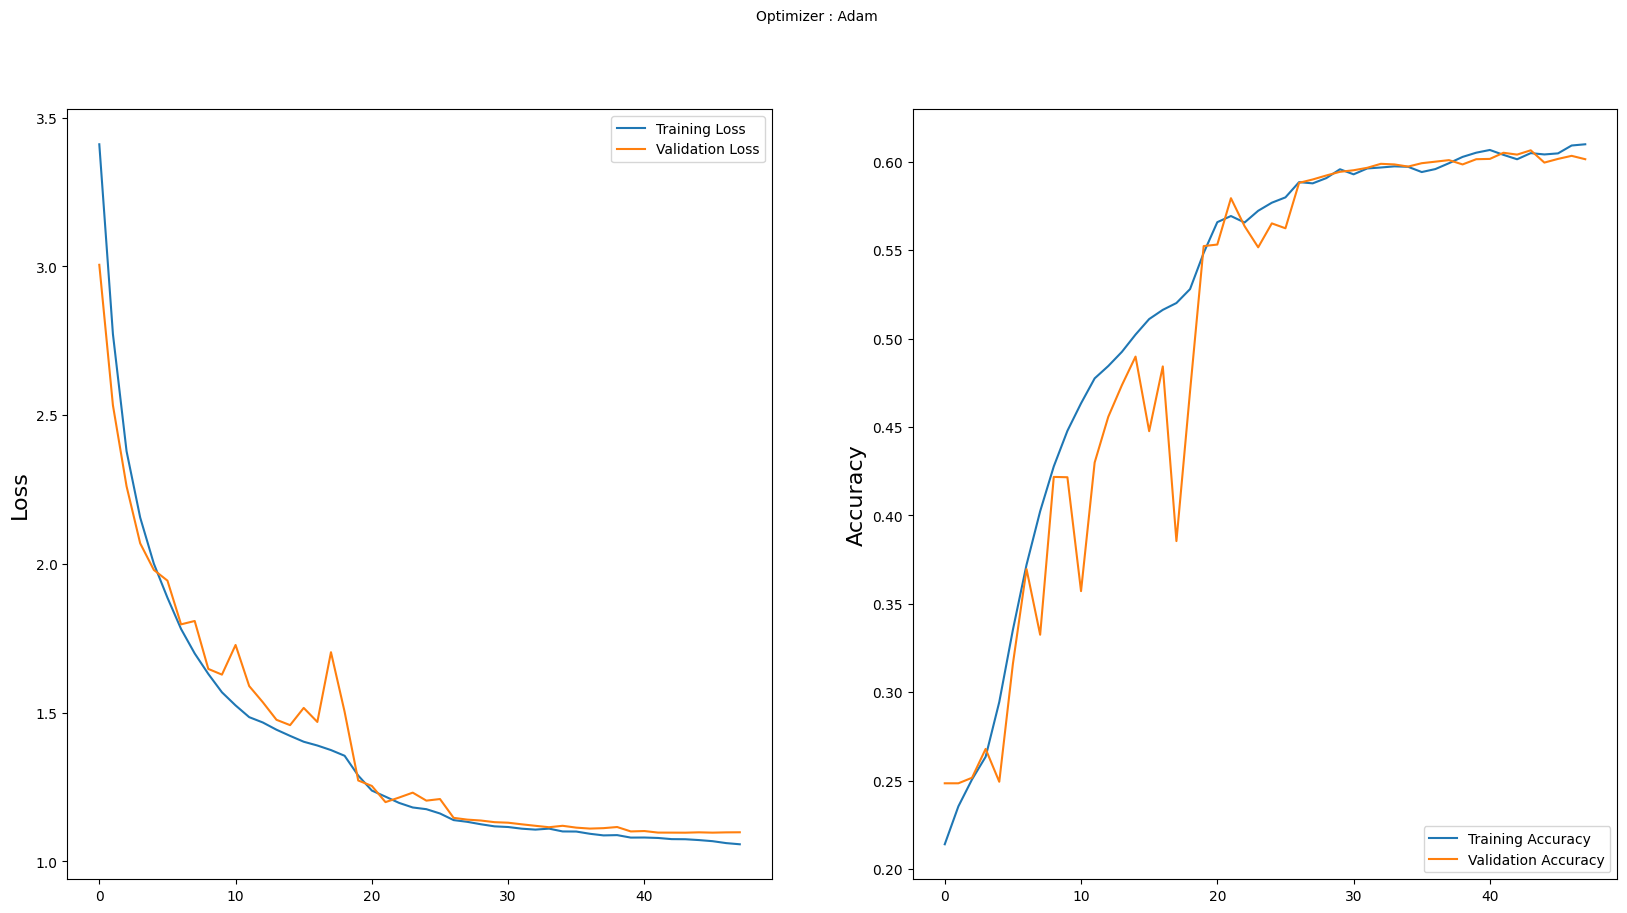

In [75]:
# Plotting Accuracy & Loss
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.suptitle("Optimizer : Adam", fontsize=10)
plt.ylabel("Loss", fontsize=16)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")

plt.subplot(1, 2, 2)
plt.ylabel("Accuracy", fontsize=16)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.show()

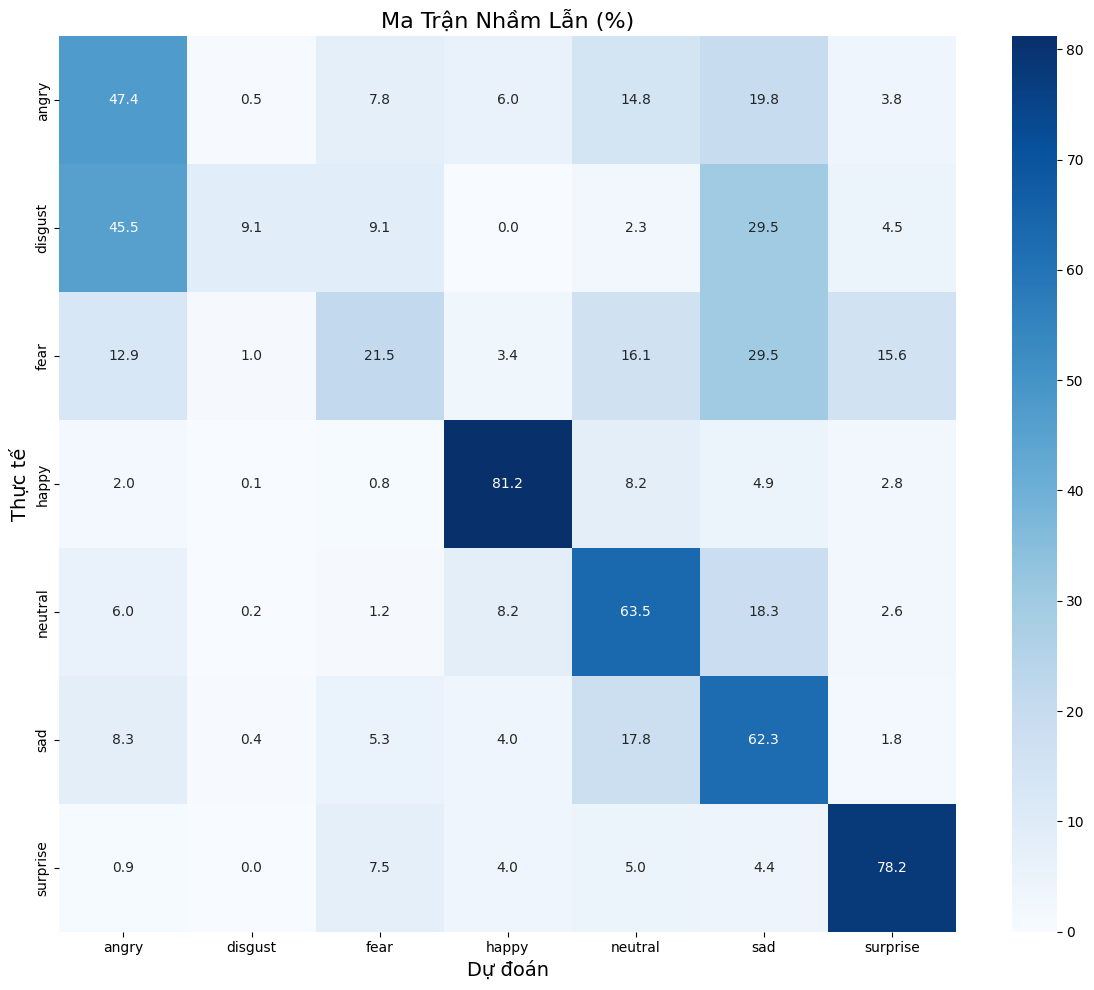

Báo cáo Phân loại:
              precision    recall  f1-score   support

       angry       0.54      0.47      0.50       399
     disgust       0.29      0.09      0.14        44
        fear       0.48      0.21      0.30       410
       happy       0.84      0.81      0.82       717
     neutral       0.52      0.63      0.57       498
         sad       0.47      0.62      0.53       494
    surprise       0.67      0.78      0.72       321

    accuracy                           0.60      2883
   macro avg       0.54      0.52      0.51      2883
weighted avg       0.60      0.60      0.59      2883



/tmp/ipykernel_31/1025158128.py:52: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  misclassified_idx = np.where(y_true != y_pred)[0]


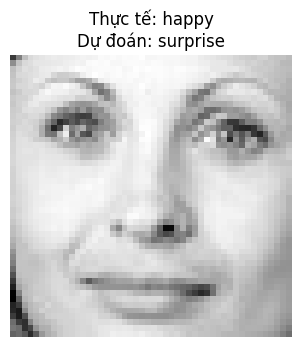

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Với cấu trúc dữ liệu mới, không cần reset generator
# vì chúng ta đã tạo generator riêng cho tập test

# Dự đoán trên tập kiểm tra
Y_pred = []
Y_true = []

# Lấy dự đoán cho toàn bộ tập test
steps = len(test_images) // batch_size + (0 if len(test_images) % batch_size == 0 else 1)

for i in range(steps):
    X_batch, y_batch = next(test_set)
    y_pred = model.predict(X_batch, verbose=0)
    
    # Chuyển đổi từ one-hot encoding sang nhãn lớp
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_batch, axis=1)
    
    Y_pred.extend(y_pred_classes)
    Y_true.extend(y_true_classes)

# Lấy tên các lớp từ mapping đã tạo trong quá trình tải dữ liệu
class_names = list(class_mapping.values())

# Tạo confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Chuẩn hóa ma trận để hiển thị dưới dạng phần trăm
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Thiết lập kích thước hình và tạo heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Dự đoán', fontsize=14)
plt.ylabel('Thực tế', fontsize=14)
plt.title('Ma Trận Nhầm Lẫn (%)', fontsize=16)
plt.tight_layout()
plt.show()

# In báo cáo phân loại chi tiết
print('Báo cáo Phân loại:')
print(classification_report(Y_true, Y_pred, target_names=class_names))

# Phân tích các ảnh bị phân loại sai
def plot_misclassified_examples(X_test, y_true, y_pred, class_names, n_examples=10):
    misclassified_idx = np.where(y_true != y_pred)[0]
    
    if len(misclassified_idx) == 0:
        print("Không tìm thấy ví dụ nào bị phân loại sai!")
        return
    
    n_examples = min(n_examples, len(misclassified_idx))
    selected_idx = np.random.choice(misclassified_idx, n_examples, replace=False)
    
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(selected_idx):
        plt.subplot(2, 5, i+1)
        # Chuyển từ (H,W,1) về (H,W) để hiển thị
        img = test_images[idx].reshape(picture_size, picture_size)
        plt.imshow(img, cmap='gray')
        plt.title(f"Thực tế: {class_names[y_true[idx]]}\nDự đoán: {class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Hiển thị một số ví dụ bị phân loại sai
plot_misclassified_examples(test_images, Y_true, Y_pred, class_names)